# **Rodrigo_Mesquita_PB_TP4**
## **Projeto de Bloco: Inteligência Artificial e Machine Learning [24E1_5]**

**Objetivos:**

* Investigar a eficácia do uso de clusters gerados pelo algoritmo K-Médias como features adicionais em tarefas de classificação.
* Comparar o desempenho de modelos SVM treinados com e sem o uso dessas features derivadas de clusterização em conjuntos de dados variados.
* Avaliar a influência do número de clusters e da seleção de parâmetros no desempenho do modelo SVM final.
* Desenvolver diretrizes para a aplicação efetiva de técnicas de clusterização em engenharia de features para aprendizado supervisionado.

## 1.Clusterização K-Médias: Utilizaremos o algoritmo K-Médias para agrupar os dados do conjunto de treinamento. O número ótimo de clusters será determinado com base em métricas como o método do cotovelo e o índice de silhueta.

In [3]:
from sklearn.datasets import load_iris, load_digits, load_breast_cancer, load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd

In [35]:
def carregar_df_e_treinar_kmeans(nome_dataset):
    #Carregar e splitar o dataset
    df = nome_dataset()
    X,Y = df.data, df.target
    X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

    #Countar Valores por Classe
    print('Quantidade de amostras por classe')
    print(pd.DataFrame(Y).value_counts())

    #Treinar o Kmeans e iterar com diferentes valores de K para avaliar a quantidade idade, utilizando os métodos elbow e silhouette
    elbow, silhouette = {},{}
    for k in range(2, 31, 1):
        model = KMeans(n_clusters= k, max_iter=1000).fit(X)
        preds = model.predict(X)
        elbow[k], silhouette[k] = model.inertia_, silhouette_score(X, preds)

    #Plortar os gráficos de Elbow e Silhouete
    maximo = max(elbow.values())
    for key in elbow:
        elbow[key] = float(elbow[key]) / maximo

    #Elbow
    fig, ax1 = plt.subplots(figsize=(8, 4))
    ax1.plot(list(elbow.keys()), list(elbow.values()), label="Método Elbow", color='b')
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_ylabel('SSE', fontsize=12, color='b')
    ax1.set_ylim(0, 1)
    ax1.tick_params('y', colors='b')
    ax1.legend(loc='upper right')

    #Ajustar o Xticks para que seja de 1 em 1
    ax1.set_xticks(list(elbow.keys()))
    ax1.set_xticklabels(list(elbow.keys()))
    #Adicionar grid vertical
    ax1.grid(visible=True, axis='x', linestyle='-', color='gray', alpha=0.5)
    #Silhouete
    ax2 = ax1.twinx()
    ax2.plot(list(silhouette.keys()), list(silhouette.values()), label="Método Silhouette", color='r')
    ax2.set_ylabel('Silhouette Score', fontsize=12, color='r')
    ax2.set_ylim(0, 1)
    ax2.tick_params('y', colors='r')
    ax2.legend(loc='upper center')

    plt.title('Elbow Plot e Silhouette Plot')
    plt.show()

## 1.Execução com Dataset IRIS (Melhor K = 6)

RESULTADO DATASET IRIS
Quantidade de amostras por classe
0
0    50
1    50
2    50
Name: count, dtype: int64


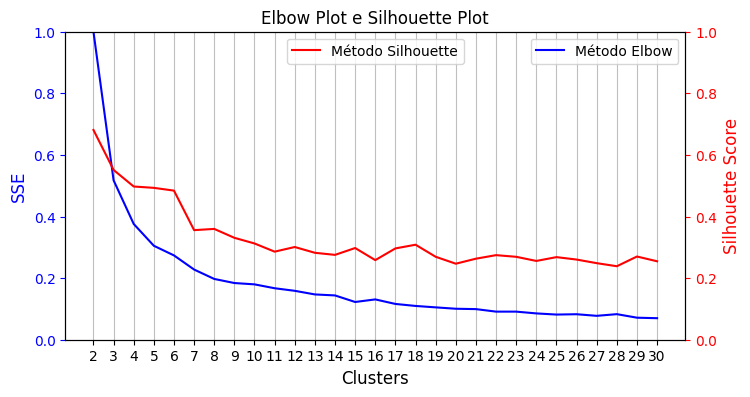

In [27]:
print('RESULTADO DATASET IRIS')
carregar_df_e_treinar_kmeans(load_iris)

## 1.Execução com Dataset DIGITS (Melhor K = 15)

RESULTADO DATASET DIGITS
Quantidade de amostras por classe
0
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64


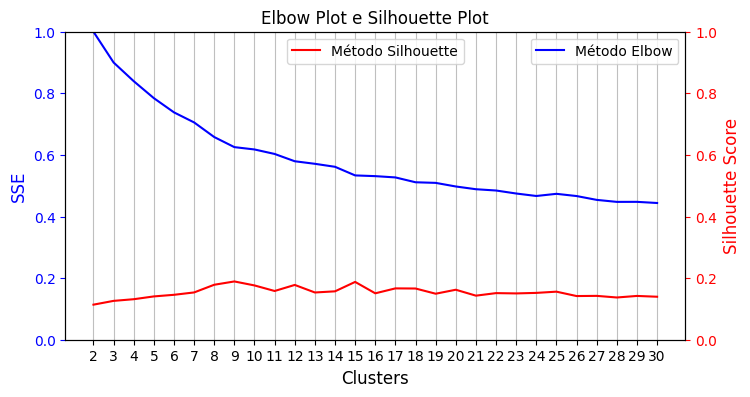

In [36]:
print('RESULTADO DATASET DIGITS')
carregar_df_e_treinar_kmeans(load_digits)

### 1. Execução com Dataset WINE (Melhor K = 10)

RESULTADO DATASET WINE
Quantidade de amostras por classe
0
1    71
0    59
2    48
Name: count, dtype: int64


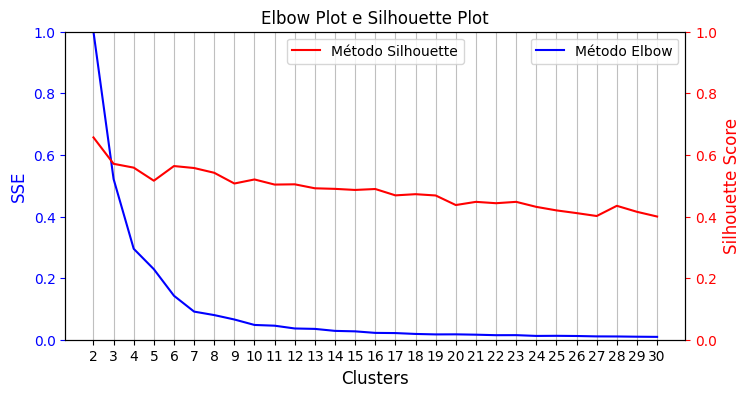

In [38]:
print('RESULTADO DATASET WINE')
carregar_df_e_treinar_kmeans(load_wine)

### 1. Execução com Dataset WINE (Melhor K = 9)

RESULTADO DATASET BREAST CANCER
Quantidade de amostras por classe
0
1    357
0    212
Name: count, dtype: int64


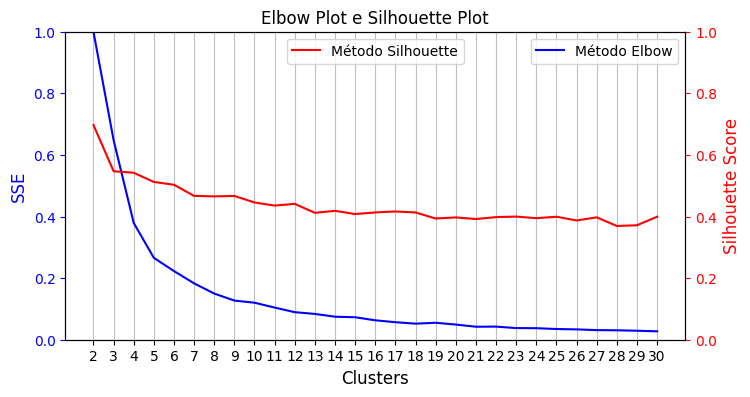

In [40]:
print('RESULTADO DATASET BREAST CANCER')
carregar_df_e_treinar_kmeans(load_breast_cancer)

## 2.Criação de Features: Para cada instância nos conjuntos de treinamento e teste, será gerada uma nova feature indicando a distância da instância ao centro do cluster mais próximo. Este processo visa incorporar a estrutura de agrupamento dos dados como uma informação adicional para o modelo de aprendizado supervisionado.

## 3.Modelo de ML: Serão treinados utilizando tanto o conjunto de features original quanto o conjunto de features expandido com as distâncias dos clusters. Use:

### 3a.Modelos SVM com diferentes configurações de kernel (linear, polinomial, RBF) e parâmetros de regularização para otimizar o desempenho.


### 3b.Modelos Random Forest com diferentes parâmetros para otimizar o desempenho.

## 4.Avaliação de Modelos: O desempenho dos modelos será avaliado com base em métricas de classificação padrão, como precisão, recall, F1-score e AUC-ROC, utilizando os conjuntos de teste.

## 5.Análise Comparativa: Será realizada uma análise comparativa para avaliar o impacto da adição das features de clusterização no desempenho dos modelos de ML. Além disso, será discutida a influência do número de clusters e das configurações do ML nas métricas de desempenho. Use gráficos para ilustrar seus argumentos.